## Libraries

In [19]:
%matplotlib inline
from functools import reduce
import pandas as pd
import os, fnmatch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib as mpl
import pickle as pkl

In [20]:
def readDat(files, path, time_zone, from_wrf = True):
    """
    Read time series csv files for each station code from a specific path
    
    Parameters
    ----------
    files : str list
        name of csv files
    path  : str
        path location
    time_zone : str
        for instance 'America/Sao_Paulo'
    
    Returns
    -------
    Pandas DataFrame
    """
    Data = pd.DataFrame()
    
    if from_wrf:
        for file in files:
            df = pd.read_csv(path + file)
            Data = pd.concat([Data,df])
        Data = Data[Data.code.isin(stations.code)]
        Data['station'] = [stations[stations.code == i].name.values[0] for i in Data.code]
        Data['type'] = [stations[stations.code == i].type.values[0] for i in Data.code]
        Data.loc[:,'date'] = pd.to_datetime(Data['date'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize("UTC")
        Data.loc[:,'local_date']=Data['date'].dt.tz_convert(time_zone)
        return Data
    
    else: # observations
        for file in files:
            df = pd.read_csv(path + file)
            Data = pd.concat([Data,df])
        Data = Data[Data.code.isin(stations.code)]
        Data['station'] = [stations[stations.code == i].name.values[0] for i in Data.code]
        Data['type'] = [stations[stations.code == i].type.values[0] for i in Data.code]
        Data.loc[:,'date'] = pd.to_datetime(Data['date'], format='%Y-%m-%d %H:%M:%S')
        Data.rename(columns={'date':'local_date'}, inplace = True)
        Data.loc[:,'local_date']=Data['local_date'].dt.tz_localize(time_zone)
        return Data

def subplots(df,pol,ylabel,xlabel,suffixes,legend, size, n_yticks, n_xticks,filename,alpha,lw,markersize,labelsize, by):
    """
    Return lineplot subplots by station only completed data to be compared.
    
    Parameters
    ----------
    df       : pandas DataFrame with datetime as index
               time series with colnames as station and meteorological and air quality parameters
    pol      : str
               air quality parameter, for instance, pol = 'o3'
    ylabel   : str
    xlabel   : str
    suffixes : list of two strings, for instance suffixes = ['_obs','_mod']
    legend   : list of two strings
    size     : tuple, default size = (6,8)
    n_yticks : int
               Number of yaxis labels
    n_xticks : int
               Interval number of xaxis labels               
    path     : str
               path location where the figure will be located
    name     : str
               suffix name of figure
    alpha    : float between 0 and 1. Default 0.7
    lw       : int
    markersize : int
    labelsize : int
    by       : str
               subplots by specific name based column names
    
    Returns
    -------
    Figure exported as pdf plot in a specific path
    
    """
    df_1 = df[['station','type',pol+suffixes[0],pol+suffixes[1]]].dropna()
    locs = list(df_1.sort_values(by=by,ascending=True)[by].unique())
    
    fig, ax = plt.subplots(df_1[by].nunique(),
                           figsize=size, 
                           sharex=True, sharey=True,
                           gridspec_kw={'hspace':0.4}, 
                           subplot_kw={'ylabel':ylabel,'xlabel':xlabel})
    for i in range(df_1[by].nunique()):
        df_1.loc[df_1[by] == locs[i]][pol+suffixes[0]].\
        plot(ax=ax[i],color='k', marker='.',linestyle='none',
             markersize=markersize, label=legend[0])
        df_1.loc[df_1[by] == locs[i]][pol+suffixes[1]].\
        plot(ax=ax[i],color='g', linestyle='-',lw=lw, alpha=alpha, label=legend[1])
        ax[0].xaxis.set_major_formatter(md.DateFormatter('%a-%d'))
        ax[0].xaxis.set_major_locator(md.DayLocator(np.arange(0,31,n_xticks)))
        ax[0].xaxis.set_minor_locator(md.MonthLocator())
        ax[0].xaxis.set_minor_formatter(md.DateFormatter('\n\n\n%b-%y'))
        ax[i].yaxis.set_major_locator(plt.MaxNLocator(n_yticks))
        ax[i].tick_params(axis='both', which='minor', labelsize=labelsize)
        ax[i].tick_params(axis='both', labelsize=labelsize)
        ax[i].set_xlabel(xlabel)
        ax[i].set_title(locs[i],size=8, loc='left')
        if i == len(df_1[by].unique())-1:
            ax[i].legend(fontsize=7)
    fig.savefig(filename+'_subplot_'+pol+'.pdf',bbox_inches='tight')


In [21]:
stations = pd.read_csv('../1_ObsData/stations.csv')
not_stations = ['Santos',
                'Santos-Ponta da Praia',
                'Cubatão-Centro',
                'Cubatão-Vale do Mogi',
                'Cubatão-V.Parisi']
stations = stations.loc[(~stations.name.isin(not_stations)) & \
                        (stations.domain =='d02')]\
            .drop('domain', axis=1).sort_values(by='code')
stations.index =stations.code
stations.head()

,name,lat,lon,code,type,abb
code,,,,,,
0,IAG,-23.651200,-46.622400,0,Forest preservation,IAG
63,Santana,-23.505993,-46.628960,63,Urban,Stna
64,Santo Amaro,-23.654977,-46.709998,64,Urban,SAm
65,Mauá,-23.668549,-46.466000,65,Urban,Maua
67,Sorocaba,-23.502427,-47.479030,67,Regional urban,Srcb


In [22]:
# Import and join Obs and Mod data
filename = 'data_exp11.pkl' # as pandas DataFrame
fname_1 = 'Obs_dic.pickle'     # as Dictionary
fname_2 = 'Mod_dic_exp11.pickle'     # as Dictionary
#filename = 'alldata_Sep18.pkl'
#fname_1 = 'Obs_dic.pickle'
#fname_2 = 'Mod_dic.pickle'

if os.path.exists(filename) is False:
    # Meteorological parameters observations
    Dir = '../1_ObsData/SEP18/'
    f18 = fnmatch.filter(os.listdir(Dir), 'all_met*.csv')
    metObs = readDat(f18, path = Dir, time_zone='America/Sao_Paulo',from_wrf = False)

    # Air quality parameters observations
    f18 = fnmatch.filter(os.listdir(Dir), 'all_photo*.csv')
    aqObs = readDat(f18, path = Dir, time_zone='America/Sao_Paulo', from_wrf = False)
    Obs = pd.merge(metObs, aqObs)
    Obs['nox']=Obs.no+Obs.no2
    #start_remove = pd.to_datetime('2018-09-14').tz_localize('America/Sao_Paulo')
    #end_remove = pd.to_datetime('2018-09-16').tz_localize('America/Sao_Paulo')
    #Obs = Obs.loc[(Obs.local_date < start_remove) | (Obs.local_date > end_remove)]
       # As dictionary
    Obs_dic = {}
    for code in stations.code:
        Obs_dic[stations.name[stations.code == code].values[0]] = (Obs[Obs.code==code])

    # WRF-Chem output 
    Dir = '../3_Validation/out/exp11/'
    f18 = fnmatch.filter(os.listdir(Dir), '*FNL_d02*')

    Mod = readDat(f18, path = Dir,time_zone='America/Sao_Paulo', from_wrf=True)
    Mod.rename(columns={'name':'station'})
    Mod = Mod[['local_date','code','station','type','tc','rh','ws','wd','o3','no','no2','co']]
    Mod['nox'] = Mod.no+Mod.no2
      # As dictionary
    Mod_dic = {}
    for code in stations.code:
        Mod_dic[stations.name[stations.code == code].values[0]] = (Mod[Mod.code==code])

    data = pd.merge(Obs, Mod,
                    on=['local_date','station','code','type'],
                    suffixes=('_obs', '_mod'))
    # to pickle
    data.to_pickle(filename)
    pkl.dump(Obs_dic, open(fname_1, "wb"))
    pkl.dump(Mod_dic, open(fname_2, "wb"))

else:
    data = pd.read_pickle(filename)
    Obs_dic = pkl.load(open(fname_1, "rb"))
    Mod_dic = pkl.load(open(fname_2, "rb"))

# Rolling 8 hour mean
o3 = data[['local_date','station','type', 'o3_obs','o3_mod']].set_index('local_date')
roll_o3 = {}
rollo3 = pd.DataFrame()
for i in o3.station.unique():
    roll_o3[i] = (o3[o3.station == i].rolling(window=8).mean()[['o3_obs','o3_mod']])
    roll_o3[i]['station'] = (i)
    roll_o3[i]['type'] = (o3[o3.station == i].type)
    df = roll_o3[i]
    rollo3 = pd.concat([rollo3,df])
    rollo3['day'] = rollo3.index.day
    MDA8 = rollo3.groupby(['day','station','type']).max().reset_index().dropna()

# Hourly mean by station type
by_type = data.groupby(['local_date','type']).mean().reset_index().drop(['code'], axis=1)

## Statistical Evaluation
The Mod_statistic script was built by Mario Gavidia and with few changes done by me. Here you see the follow functions:
```python
* all_aqs_all_vars(model_dic, obs_dic, to_df=True, sort_pol=False, csv=False)
* all_aqs_some_vars(model_dic, obs_dic, var, to_df=True, sort_pol=False, csv=False)
* all_stats(model_df, obs_df, var, to_df=False)
* all_var_stats_per_station(model_df, obs_df, para=['o3', 'co', 'nox', 'tc', 'ws', 'rh'], to_df=False)
* complete_cases(model_df, obs_df, var)
* global_stat(model_dic, obs_dic, csv=False)
* global_stat_some_vars(model_dic, obs_dic, var, csv=False)
* mean_bias(model_df, obs_df, var)
* mean_gross_error(model_df, obs_df, var)
* normalized_mean_bias(model_df, obs_df, var)
* normalized_mean_error(model_df, obs_df, var)
* root_mean_square_error(model_df, obs_df, var)
* some_vars_stats_per_station(model_df, obs_df, var, to_df=False)
* wind_dir_diff(Mi, Oi)
* wind_dir_mage(model_df, obs_df, wd_name='wd')
* wind_dir_mb(model_df, obs_df, wd_name='wd')
* mod_Stats(data, polls=['o3', 'no', 'no2', 'co', 'tc', 'rh'])
```

In [23]:
import mod_stats as ms

The function mod_Stats considers each station

By station and hourly data:

In [24]:
ms.mod_Stats(data,polls=['o3', 'no', 'no2', 'nox','co']).round(2)
# data[data.type.isin(['Regional urban','Industry','Urban','Urban park'])]

,n,MB,MGE,RMSE,NMB,NME,r,Obs SD,Mod SD
o3,4322,-11.22,28.72,36.49,20.22,51.73,0.63,36.21,43.04
no,3791,3.22,10.97,25.62,-29.61,100.90,0.45,28.00,17.46
no2,3791,-2.10,22.72,31.74,6.16,66.55,0.39,24.92,31.71
nox,3791,1.12,31.76,48.91,-2.48,70.56,0.44,47.25,44.77
co,1712,0.31,0.34,0.45,-51.58,56.19,0.30,0.33,0.16


In [25]:
ms.all_aqs_all_vars(Mod_dic,Obs_dic, to_df=True).dropna().round(2).sort_values(by='R', ascending=False).loc['o3']

/Users/adelgado/Google_Drive/USP/Dissertation/data/PythonWRF/mod_stats.py:134: RuntimeWarning: invalid value encountered in double_scalars
  nmb = (df.wrf - df.obs).sum() / df.obs.sum() * 100
/Users/adelgado/Google_Drive/USP/Dissertation/data/PythonWRF/mod_stats.py:161: RuntimeWarning: invalid value encountered in double_scalars
  df.obs.sum() * 100)


,MB,ME,RMSE,NMB,NME,R,Om,Mm,Ostd,Mstd,aqs
o3,11.22,30.34,36.40,16.78,45.38,0.80,66.85,76.17,56.29,38.15,Paulínia
o3,4.56,18.91,23.18,5.77,23.92,0.80,79.06,82.01,37.26,33.25,Campinas-Taquaral
o3,15.66,28.21,34.88,25.75,46.37,0.76,60.83,74.32,44.63,46.71,Jundiaí
o3,30.49,32.17,38.32,55.13,58.18,0.76,55.30,84.11,27.59,36.32,Campinas-V.União
o3,17.82,22.61,26.88,27.30,34.63,0.75,65.29,82.13,30.12,19.71,Jaú
o3,12.59,23.48,28.98,17.93,33.44,0.75,70.21,81.01,39.39,29.27,Limeira
o3,5.52,23.82,28.66,12.96,55.87,0.73,42.64,49.81,40.41,51.49,Cid.Universitária-USP-Ipen
o3,17.07,29.02,35.02,26.37,44.83,0.71,64.73,83.25,43.38,35.64,Piracicaba
o3,5.27,29.78,37.85,10.40,58.68,0.69,50.74,54.00,39.31,51.97,Carapicuíba
o3,39.36,41.09,48.43,87.33,91.17,0.69,45.07,82.47,29.45,39.36,Sorocaba


/Users/adelgado/Google_Drive/USP/Dissertation/data/PythonWRF/mod_stats.py:134: RuntimeWarning: invalid value encountered in double_scalars
  nmb = (df.wrf - df.obs).sum() / df.obs.sum() * 100
/Users/adelgado/Google_Drive/USP/Dissertation/data/PythonWRF/mod_stats.py:161: RuntimeWarning: invalid value encountered in double_scalars
  df.obs.sum() * 100)


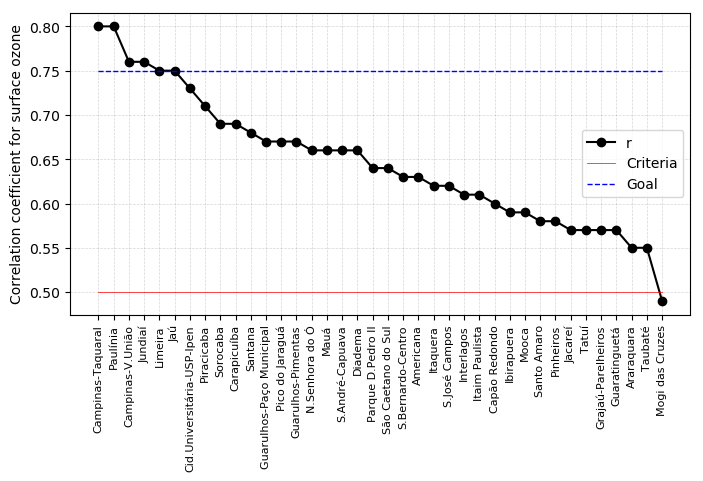

In [8]:
o3_stats = ms.all_aqs_some_vars(Mod_dic,Obs_dic, 
                     var=['o3'], 
                     to_df=True, 
                     sort_pol=True, 
                     csv=False).dropna().round(2).sort_values(by='R',ascending=False)

fig = plt.figure(figsize=(8,4), dpi=100)
plt.plot(o3_stats.aqs,o3_stats.R,'ko-', label='r')
plt.plot(o3_stats.aqs,[0.5 for i in o3_stats.aqs],'r-', label='Criteria', lw=0.5)
plt.plot(o3_stats.aqs,[0.75 for i in o3_stats.aqs],'b--', label='Goal', lw=1)
plt.xticks(o3_stats.aqs, rotation='vertical', fontsize=8)
plt.ylabel('Correlation coefficient for surface ozone')
plt.legend()
plt.grid(color='0.2', ls='--', lw=0.5,alpha=0.2)
fig.savefig('./fig/o3_r_exp11.pdf',bbox_inches='tight')

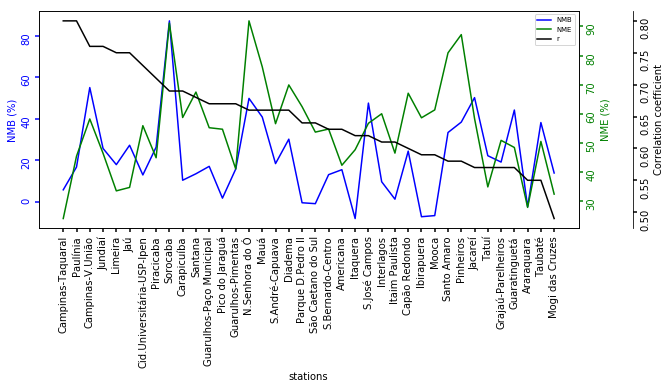

In [9]:
x = o3_stats.aqs

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


fig, host = plt.subplots(figsize=(12,4))
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
#make_patch_spines_invisible(par3)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

p1, = host.plot(x, o3_stats.NMB, "b-", label="NMB")
p2, = par1.plot(x, o3_stats.NME, "g-", label="NME")
p3, = par2.plot(x, o3_stats.R, "k-", label="r")

#host.set_xlim(0, 2)
#host.set_ylim(12, 30)
#par1.set_ylim(0, 1)
#par2.set_ylim(0, 10)

host.set_xlabel("stations")
host.set_ylabel("NMB (%)")
par1.set_ylabel("NME (%)")
par2.set_ylabel("Correlation coefficient")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5, labelrotation=90)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

lines = [p1, p2, p3]

host.legend(lines, [l.get_label() for l in lines],loc=0, fontsize='x-small');
fig.savefig('./fig/o3_stats_station_exp11.pdf',bbox_inches='tight');

In [26]:
types = list(MDA8.sort_values(by='type',ascending=True).type.unique())
o3_stats_type = {}
o3sta_df = pd.DataFrame()
for i in types:
    o3_stats_type[i] = (ms.mod_Stats(MDA8[MDA8.type.isin([i])],polls=['o3']))
    o3_stats_type[i]['type'] = (i)
    df = o3_stats_type[i]
    o3sta_df = pd.concat([o3sta_df,df]).round(2)
o3sta_df

,n,MB,MGE,RMSE,NMB,NME,r,Obs SD,Mod SD,type
o3,5,-27.37,30.24,36.93,32.29,35.67,0.70,30.30,38.54,Forest preservation
o3,5,12.21,26.40,29.94,-9.61,20.76,0.79,48.93,34.27,Industry
o3,70,-12.57,21.36,27.61,12.72,21.62,0.53,24.67,26.21,Regional urban
o3,90,-30.16,30.35,35.09,39.53,39.78,0.80,26.13,30.23,Urban
o3,18,-20.97,22.00,26.33,26.13,27.41,0.83,24.79,29.08,Urban park


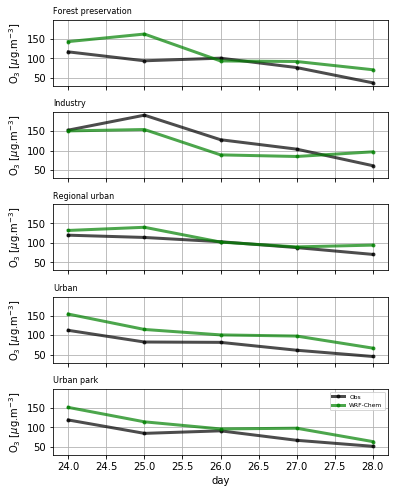

In [11]:
fig, ax = plt.subplots(len(types),
                       figsize=(6,8),
                       sharey=True,
                       sharex=True,
                       subplot_kw={'ylabel':'O$_3$ [$\mu$g.m$^{-3}$]'},
                       gridspec_kw={'hspace':0.4})
for i in range(len(types)):
    MDA8.loc[MDA8.type ==types[i]].groupby(['type','day'])\
    .mean().reset_index().set_index('day')\
    .plot(ax=ax[i], legend=False, grid=True, fontsize=10,
          color='kg', lw=3, marker='.', alpha=.7)
    ax[i].set_title(types[i],size=8, loc='left')
    if i == len(types)-1:
        ax[i].legend(['Obs','WRF-Chem'],fontsize=6)
fig.savefig('./fig/MDA8_type_exp11.pdf',bbox_inches='tight')

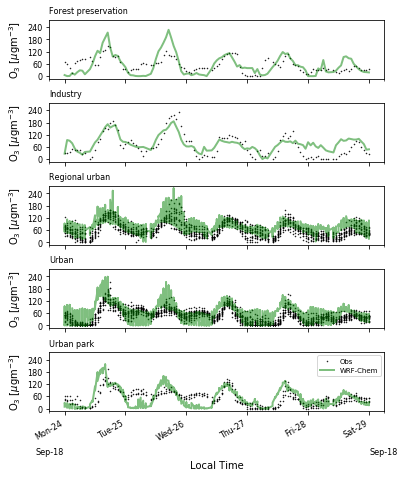

In [17]:
subplots(data.set_index('local_date'), #[data.station.isin(gr_1)]
         pol='o3',
         ylabel='O$_3$ [$\mu$gm$^{-3}$]',
         xlabel='Local Time',
         suffixes=['_obs','_mod'],
         legend=['Obs','WRF-Chem'],
         size=(6,8),
         n_yticks=5,
         n_xticks=1,
         filename='fig/exp11_type',
         alpha=.5,
         markersize=1,
         lw=2,
         labelsize=8, 
         by='type')

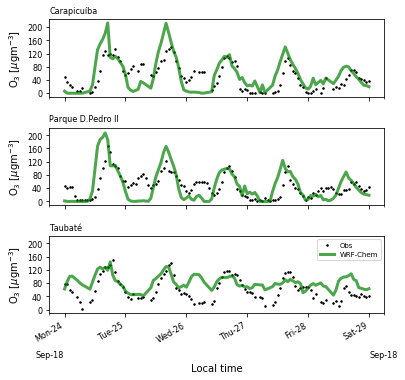

In [18]:
subplots(data.set_index('local_date').dropna(), pol='o3', by ='station',
         ylabel='O$_3$ [$\mu$gm$^{-3}$]',
         xlabel = 'Local time',
         suffixes = ['_obs','_mod'],
         legend = ['Obs','WRF-Chem'],
         size = (6,6),
         n_yticks=6,
         n_xticks=1,
         filename='fig/exp11_station',
         markersize=3,alpha=0.7,lw=3, labelsize=8)

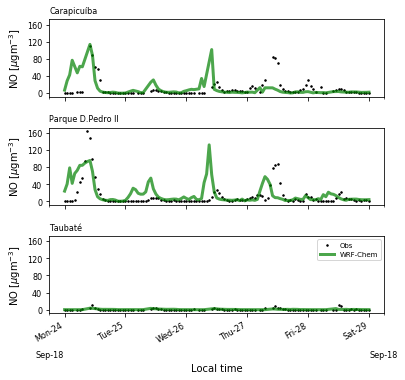

In [14]:
subplots(data.set_index('local_date').dropna(), pol='no', by ='station',
         ylabel='NO [$\mu$gm$^{-3}$]',
         xlabel = 'Local time',
         suffixes = ['_obs','_mod'],
         legend = ['Obs','WRF-Chem'],
         size = (6,6),
         n_yticks=6,
         n_xticks=1,
         filename='fig/exp11',
         markersize=3,alpha=0.7,lw=3, labelsize=8)

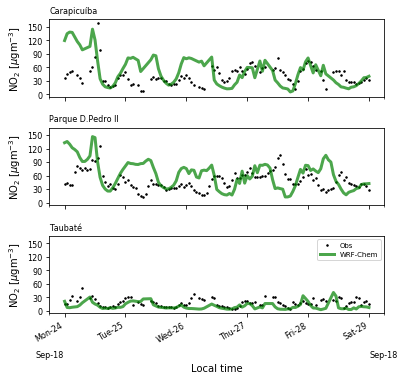

In [15]:
subplots(data.set_index('local_date').dropna(), pol='no2', by ='station',
         ylabel='NO$_2$ [$\mu$gm$^{-3}$]',
         xlabel = 'Local time',
         suffixes = ['_obs','_mod'],
         legend = ['Obs','WRF-Chem'],
         size = (6,6),
         n_yticks=6,
         n_xticks=1,
         filename='fig/exp11',
         markersize=3,alpha=0.7,lw=3, labelsize=8)

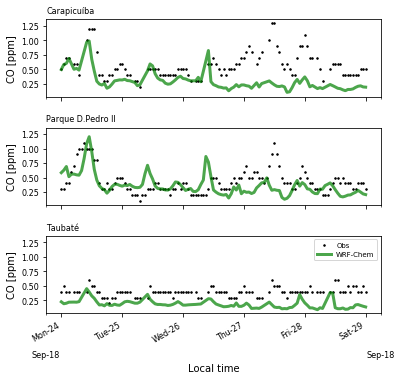

In [16]:
subplots(data.set_index('local_date').dropna(), pol='co', by ='station',
         ylabel='CO [ppm]',
         xlabel = 'Local time',
         suffixes = ['_obs','_mod'],
         legend = ['Obs','WRF-Chem'],
         size = (6,6),
         n_yticks=6,
         n_xticks=1,
         filename='fig/exp11',
         markersize=3,alpha=0.7,lw=3, labelsize=8)